In [1]:
import pickle
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch import fit_gpytorch_mll
from botorch.exceptions import InputDataWarning
from botorch.models import SingleTaskGP
from gpytorch import ExactMarginalLogLikelihood
from scipy.signal import medfilt

from hysteresis.base import BaseHysteresis
from hysteresis.hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

filterwarnings("ignore", category=InputDataWarning)

### Import data from beam measurements
Data we are interested in is the measurement of beam current `L1:CM2:measCurrentCM`
as a function of the magnet readback `L1:RG2:QM3:CurrentAI`.

In [2]:
# get data from dataframe - ignores static initial values
data = pickle.load(open("data/QM3hystscan_2022_01_18.pkl", "rb"))
print(list(data.keys()))
current = np.array(data["L1:RG2:QM3:CurrentAI"])
beam_charge = np.array(data["L1:CM2:measCurrentCM"])
# median filter to smooth high frequency jitter in charge data
beam_charge_smooth = medfilt(beam_charge[1], 21)
print(len(beam_charge_smooth))

['L1:RG2:QM3:CurrentAO', 'L1:RG2:QM3:CurrentAI', 'L1:RG2:CM1:measCurrentCM', 'L1:CM2:measCurrentCM', 'L3:CM1:measCurrentCM', 'L1:P1:BPM.XPOS', 'L1:P1:BPM.YPOS', 'L1:P1:BPM.VAL', 'L2:P1:BPM.XPOS', 'L2:P1:BPM.YPOS', 'L2:P1:BPM.VAL', 'L2:P2:BPM.XPOS', 'L2:P2:BPM.YPOS', 'L2:P2:BPM.VAL', 'L2:P3:BPM.XPOS', 'L2:P3:BPM.YPOS', 'L2:P3:BPM.VAL', 'L2:P4:BPM.XPOS', 'L2:P4:BPM.YPOS', 'L2:P4:BPM.VAL', 'L3:P1:BPM.XPOS', 'L3:P1:BPM.YPOS', 'L3:P1:BPM.VAL', 'L3:P2:BPM.XPOS', 'L3:P2:BPM.YPOS', 'L3:P2:BPM.VAL']
11211


Text(0, 0.5, 'Beam charge')

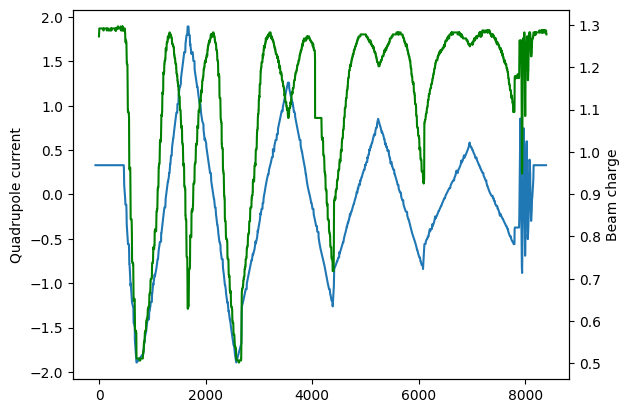

In [3]:
fig, ax = plt.subplots()
ax.plot(*current)
ax.set_ylabel("Quadrupole current")
ax2 = ax.twinx()
ax2.plot(beam_charge[0], beam_charge_smooth, color="green")
ax2.set_ylabel("Beam charge")

### Synchronize measurements of quadrupole readbacks and beam measurements

(736, 2)


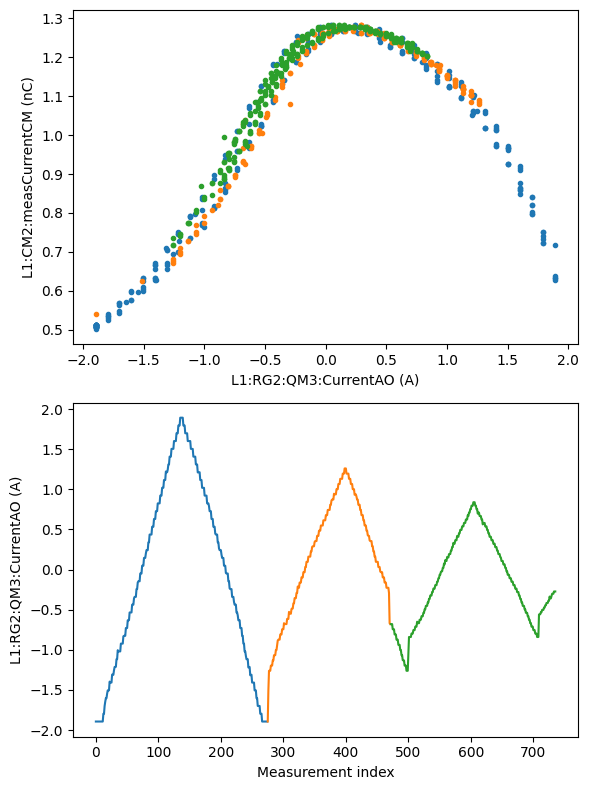

In [4]:
# bin measured current based on timestamps for current read back
start_idx = 43
end_idx = -200
timestamps = current[0][start_idx:end_idx]
currents = current[1][start_idx:end_idx]
beam_charge_binned = []
for i in range(len(timestamps) - 1):
    beam_charge_binned += [
        beam_charge_smooth[
            np.argwhere(
                (beam_charge[0] > timestamps[i]) & (beam_charge[0] < timestamps[i + 1])
            )
        ]
    ]

skip = 10
beam_charge_full = []
for i in range(len(currents) - 1):
    for ele in beam_charge_binned[i]:
        beam_charge_full += [[currents[i], ele[0]]]
beam_charge_full = np.asarray(beam_charge_full)[::skip]
print(beam_charge_full.shape)

# indices to sep cycles
cycle_indicies = np.array([0, 275, 472, len(beam_charge_full)]) * 10 / skip
cycle_indicies = cycle_indicies.astype("int")

fig, (ax, ax2) = plt.subplots(2, 1)
fig.set_size_inches(6, 8)
step = np.arange(len(beam_charge_full))

ax.set_xlabel("L1:RG2:QM3:CurrentAO (A)")
ax.set_ylabel("L1:CM2:measCurrentCM (nC)")

ax2.set_xlabel("Measurement index")
ax2.set_ylabel("L1:RG2:QM3:CurrentAO (A)")
for i in range(len(cycle_indicies) - 1):
    ax.plot(
        *beam_charge_full[cycle_indicies[i] : cycle_indicies[i + 1]].T, ".", c=f"C{i}"
    )

    ax2.plot(
        step[cycle_indicies[i] : cycle_indicies[i + 1]],
        beam_charge_full[cycle_indicies[i] : cycle_indicies[i + 1]].T[0],
        c=f"C{i}",
    )
fig.tight_layout()
# fig.savefig('experiment_data.png', dpi=300)

#### Characterize statistics of binned measurements for each timestep (not necessary for modeling)

(468,)


<ErrorbarContainer object of 3 artists>

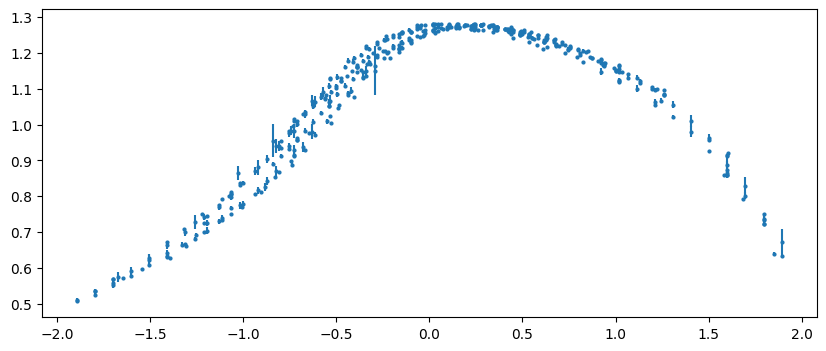

In [5]:
beam_charge_mean = np.array(
    [np.mean(ele) if len(ele) != 0 else np.nan for ele in beam_charge_binned]
)
beam_charge_std = np.array(
    [np.std(ele) if len(ele) != 0 else np.nan for ele in beam_charge_binned]
)
print(currents.shape)

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
ax.errorbar(currents[:-1], beam_charge_mean, beam_charge_std, fmt="o", ms=2)

#### Create joint hysteresis-Gaussian model using experimental data

In [6]:
train_x = beam_charge_full[:, 0]
train_y = beam_charge_full[:, 1]

# set up training data for joint hysteresis model
train_x = torch.tensor(train_x).double().reshape(-1, 1)
train_y = torch.tensor(train_y).double()


# create hysteresis model based on training inputs (quadrupole current) - see
# documentation of `BaseHysteresis` for details
H = BaseHysteresis(
    train_x.flatten(), polynomial_degree=1, mesh_scale=0.1, trainable=True
)

# create joint/hybrid model of beam response using BaseHysteresis object
model = ExactHybridGP(train_x, train_y.flatten().clone(), H)
mll = ExactMarginalLogLikelihood(model.gp.likelihood, model)

Create normal GP model for comparison

In [7]:
gp = SingleTaskGP(
    train_x,
    train_y.reshape(-1, 1),
    outcome_transform=None,  # To reproduce the previous result, in botorch now it's defaulted to Standardize
)
gp_mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

Train models

In [8]:
res = fit_gpytorch_mll(mll)
gp_res = fit_gpytorch_mll(gp_mll)

Visualize hysteron density from trained models

In [9]:
for param in model.hysteresis_models[0].parameters():
    print(param)

Parameter containing:
tensor([-1.0558e-05, -1.0521e-05,  1.5990e-05,  ..., -9.2578e-06,
        -9.2131e-06, -1.0515e-05], requires_grad=True)
Parameter containing:
tensor([-3.1766e-16], requires_grad=True)
Parameter containing:
tensor([-7.4442], requires_grad=True)
Parameter containing:
tensor([0.0099], requires_grad=True)
Parameter containing:
tensor([-3.6313e-06], requires_grad=True)
Parameter containing:
tensor([-3.1766e-19], requires_grad=True)


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.collections.PolyCollection at 0x7f4062677e00>)

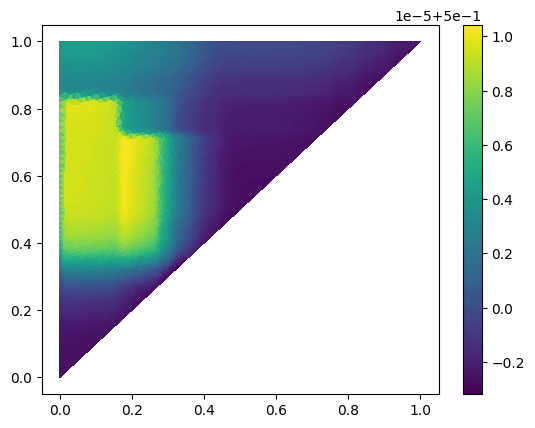

In [10]:
plot_hysterion_density(model.hysteresis_models[0])

Generate plot for PRL

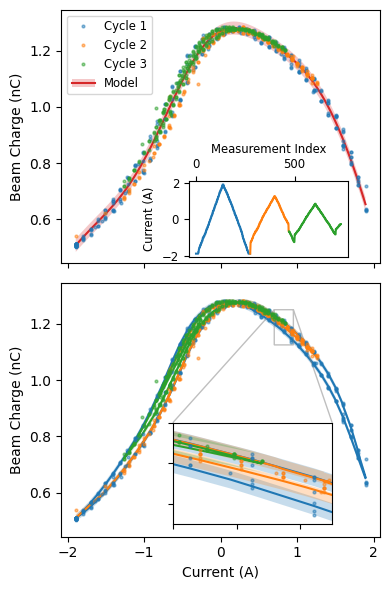

In [11]:
# compare fit to data

# use joint model to predict the mean and confidence region at training points
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - std).flatten()
    u = (mean_out + std).flatten()

# use normal GP model to predict the mean and confidence region throughout training
# domain
test_x = torch.linspace(*model.hysteresis_models[0].valid_domain, 100).double()
with torch.no_grad():
    gp_post = gp.posterior(test_x, observation_noise=True)
    gp_mean = gp_post.mean.flatten()
    gp_std = torch.sqrt(gp_post.variance).flatten()
    gp_l = gp_mean - gp_std
    gp_u = gp_mean + gp_std
    # gp_post = gp.likelihood(gp(test_x))
    # gp_mean = gp_post.mean
    # gp_l, gp_u = gp_post.confidence_region()


# create plots
fig, (ax2, ax) = plt.subplots(2, 1, sharex="all", sharey="all")
fig.set_size_inches(4, 6)
ms = 2

# create inset axis for joint model plot
axins = ax.inset_axes([0.35, 0.05, 0.5, 0.4])
axins.set_xlim(0.7, 0.95)
axins.set_ylim(1.125, 1.25)
axins.set_yticklabels([])
axins.set_xticklabels([])
ax.indicate_inset_zoom(axins)

# plot training data
for a in [ax, axins, ax2]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(
            train_x[cycle_indicies[i] : cycle_indicies[i + 1]],
            train_y[cycle_indicies[i] : cycle_indicies[i + 1]],
            "o",
            ms=ms,
            c=f"C{i}",
            label=f"Cycle {i+1}",
            zorder=10 + i,
            alpha=0.5,
        )


# plot sequential predictions from joint hysteresis-GP model
for a in [ax, axins]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(
            train_x[cycle_indicies[i] : cycle_indicies[i + 1]],
            mean_out[cycle_indicies[i] : cycle_indicies[i + 1]].detach(),
            f"C{i}",
        )
        a.fill_between(
            train_x.flatten()[cycle_indicies[i] : cycle_indicies[i + 1]],
            l[cycle_indicies[i] : cycle_indicies[i + 1]],
            u[cycle_indicies[i] : cycle_indicies[i + 1]],
            alpha=0.25,
            fc=f"C{i}",
        )

# plot normal GP model predictions
ax2.plot(test_x, gp_mean, "C3", label="Model")
ax2.fill_between(test_x, gp_l, gp_u, alpha=0.25, fc="C3", label="Confidence")

# fix legend handles
handles, labels = ax2.get_legend_handles_labels()
new_handles = [*handles[:-2], (handles[-2], handles[-1])]
new_labels = labels[:-1]
ax2.legend(new_handles, new_labels, loc=2, fontsize="small")

ax.set_ylabel("Beam Charge (nC)")
ax2.set_ylabel("Beam Charge (nC)")
ax.set_xlabel("Current (A)")
fig.tight_layout()

axins2 = ax2.inset_axes([0.4, 0.025, 0.5, 0.3])
axins2.set_ylabel("Current (A)", fontsize="small")
axins2.set_xlabel("Measurement Index", fontsize="small")
axins2.xaxis.tick_top()
for ele in axins2.get_xticklabels() + axins2.get_yticklabels():
    ele.set_fontsize("small")

axins2.xaxis.set_label_position("top")

step = np.arange(len(beam_charge_full))

for i in range(len(cycle_indicies) - 1):
    axins2.plot(
        step[cycle_indicies[i] : cycle_indicies[i + 1]],
        beam_charge_full[cycle_indicies[i] : cycle_indicies[i + 1]].T[0],
        c=f"C{i}",
    )


# fig.savefig('experimental_modeling_paper.png', dpi=300)

Generate plot for presentations

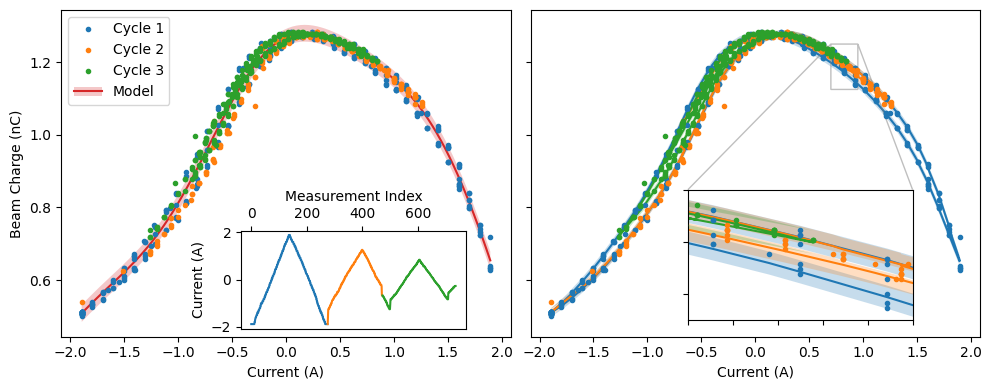

In [12]:
# compare fit to data
with torch.no_grad():
    post = model(train_x.double(), return_real=True, return_likelihood=True)
    mean_out = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()
    l = (mean_out - std).flatten()
    u = (mean_out + std).flatten()

fig, (ax2, ax) = plt.subplots(1, 2, sharex="all", sharey="all")
fig.set_size_inches(10, 4)
ms = 3


axins = ax.inset_axes([0.35, 0.05, 0.5, 0.4])
# axins.set_xlim(0.45,0.6)
# axins.set_ylim(1.225, 1.275)

axins.set_xlim(0.7, 0.95)
axins.set_ylim(1.125, 1.25)

# axins.set_xlim(1.0,1.5)
# axins.set_ylim(1.0, 1.2)

axins.set_yticklabels([])
axins.set_xticklabels([])

# plot training data
for a in [ax, axins, ax2]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(
            train_x[cycle_indicies[i] : cycle_indicies[i + 1]],
            train_y[cycle_indicies[i] : cycle_indicies[i + 1]],
            "o",
            ms=ms,
            c=f"C{i}",
            label=f"Cycle {i+1}",
            zorder=5 + i,
        )


for a in [ax, axins]:
    for i in range(len(cycle_indicies) - 1):
        a.plot(
            train_x[cycle_indicies[i] : cycle_indicies[i + 1]],
            mean_out[cycle_indicies[i] : cycle_indicies[i + 1]].detach(),
            f"C{i}",
        )
        a.fill_between(
            train_x.flatten()[cycle_indicies[i] : cycle_indicies[i + 1]],
            l[cycle_indicies[i] : cycle_indicies[i + 1]],
            u[cycle_indicies[i] : cycle_indicies[i + 1]],
            alpha=0.25,
            fc=f"C{i}",
        )
ax.indicate_inset_zoom(axins)

test_x = torch.linspace(*model.hysteresis_models[0].valid_domain, 100).double()
with torch.no_grad():
    gp_post = gp.posterior(test_x, observation_noise=True)
    gp_mean = gp_post.mean.flatten()
    gp_std = torch.sqrt(gp_post.variance).flatten()
    gp_l = gp_mean - gp_std
    gp_u = gp_mean + gp_std

ax2.plot(test_x, gp_mean, "C3", label="Model")
ax2.fill_between(test_x, gp_l, gp_u, alpha=0.25, fc="C3", label="Confidence")

handles, labels = ax2.get_legend_handles_labels()
new_handles = [*handles[:-2], (handles[-2], handles[-1])]
new_labels = labels[:-1]
ax2.legend(new_handles, new_labels)

ax.set_xlabel("Current (A)")
ax2.set_ylabel("Beam Charge (nC)")
ax2.set_xlabel("Current (A)")
fig.tight_layout()

axins2 = ax2.inset_axes([0.4, 0.025, 0.5, 0.3])
axins2.set_ylabel("Current (A)")
axins2.set_xlabel("Measurement Index")
axins2.xaxis.tick_top()
axins2.xaxis.set_label_position("top")

step = np.arange(len(beam_charge_full))

for i in range(len(cycle_indicies) - 1):
    axins2.plot(
        step[cycle_indicies[i] : cycle_indicies[i + 1]],
        beam_charge_full[cycle_indicies[i] : cycle_indicies[i + 1]].T[0],
        c=f"C{i}",
    )

# fig.savefig('experimental_modeling_presentation.png', dpi=300)